## Imports

In [15]:
import PIL.Image
from PIL.ImageColor import colormap
# Torch Imports
from torchvision.models import resnet
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import torch

# Dataset Related
import kagglehub

# Plots and numpy
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
np.random.seed(42)

import os


#Utils
from utils.plot import  plot_classes, plot_random_six_images

# Dataset
In this repo I will use *Stanford Dogs Dataset* from kaggle
https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

Originally from http://vision.stanford.edu/aditya86/ImageNetDogs/


## Getting Data

In [2]:
# Download latest version
DATA_PATH = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
IMG_PATH = os.path.join(DATA_PATH, "images", "Images")
ANNOTATION_PATH = os.path.join(DATA_PATH, "annotations", "Annotations")

print("Path to dataset files:", DATA_PATH)

Path to dataset files: /home/franio/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [3]:
dataset = datasets.ImageFolder(root=IMG_PATH)

## Transforms

Normalization is done with standard image net $\mu$ and $\sigma$

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


train_transform = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])

val_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

## Train, Val and Test Split
I will use 0.7/0.2/0.1 split
%TODO: I assume that 10k images in total is enough for fine tuning. I will reconsider this value after testing a model. -> with torch split random

In [5]:
N = len(dataset)

train_size = int(np.ceil(0.7*N))
val_size = int(np.ceil(0.2*N))
test_size = int(N - train_size - val_size)


training_set, testing_set, validation_set = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

print(f'Training set size:\t\t{len(training_set)}\n'
      f'Testing set size:\t\t{len(testing_set)}\n'
      f'Validation set size:\t{len(validation_set)}\n')

Training set size:		14406
Testing set size:		2058
Validation set size:	4116



## Data vizualzation

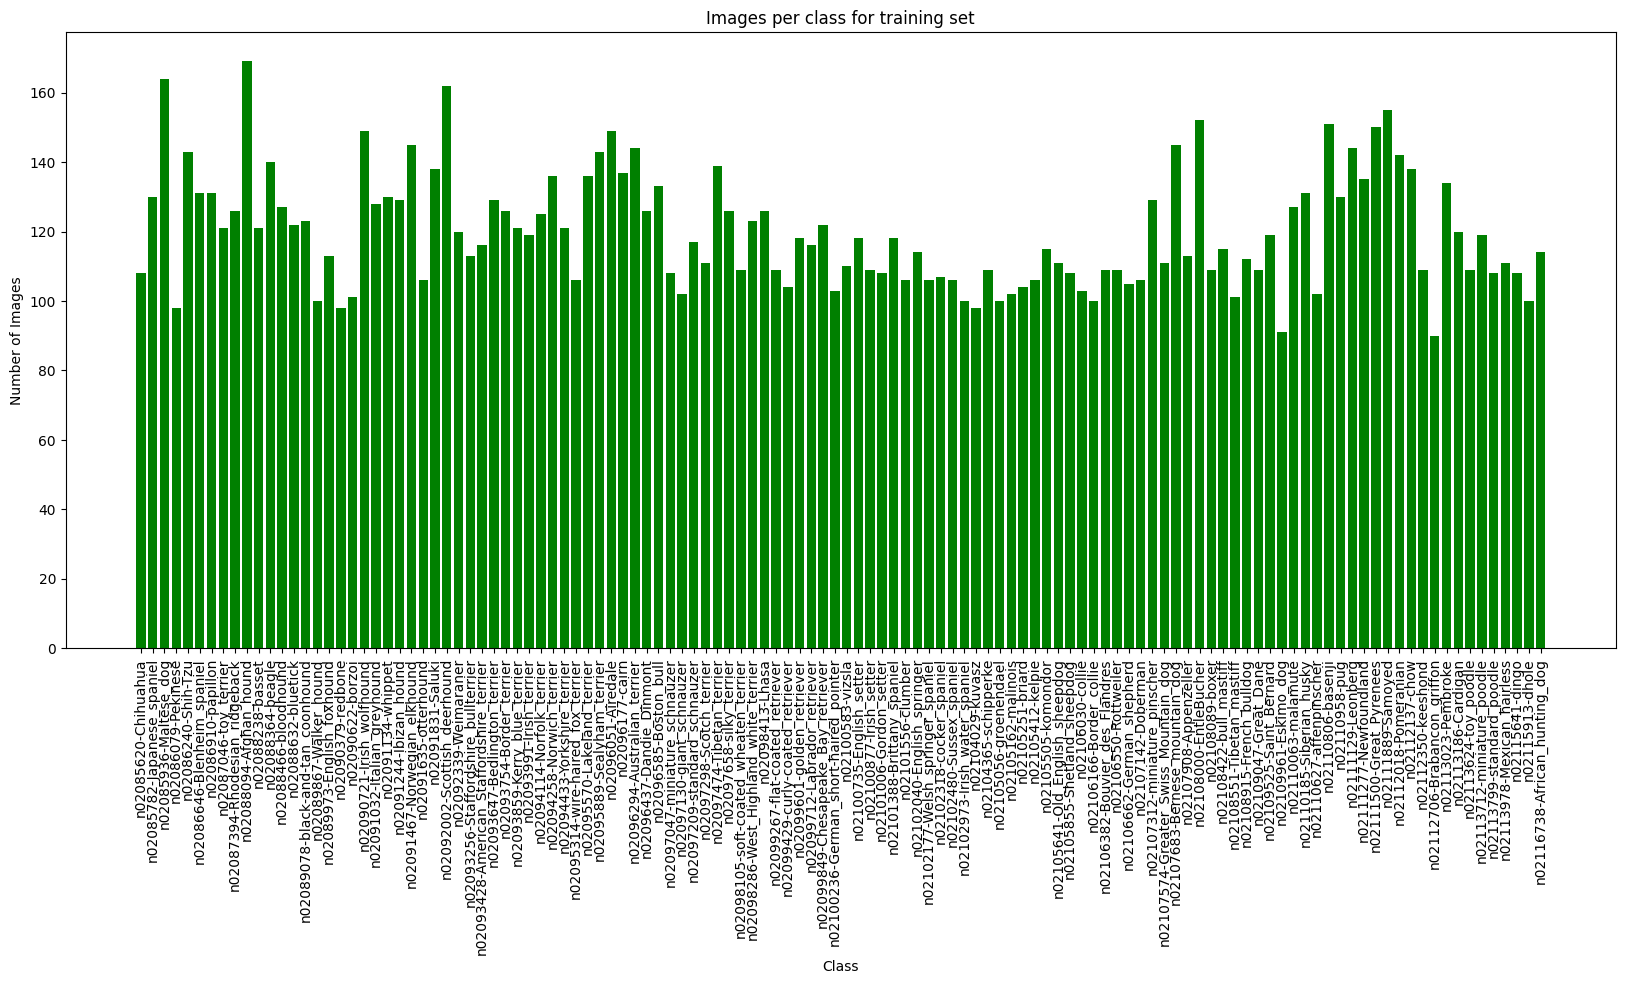

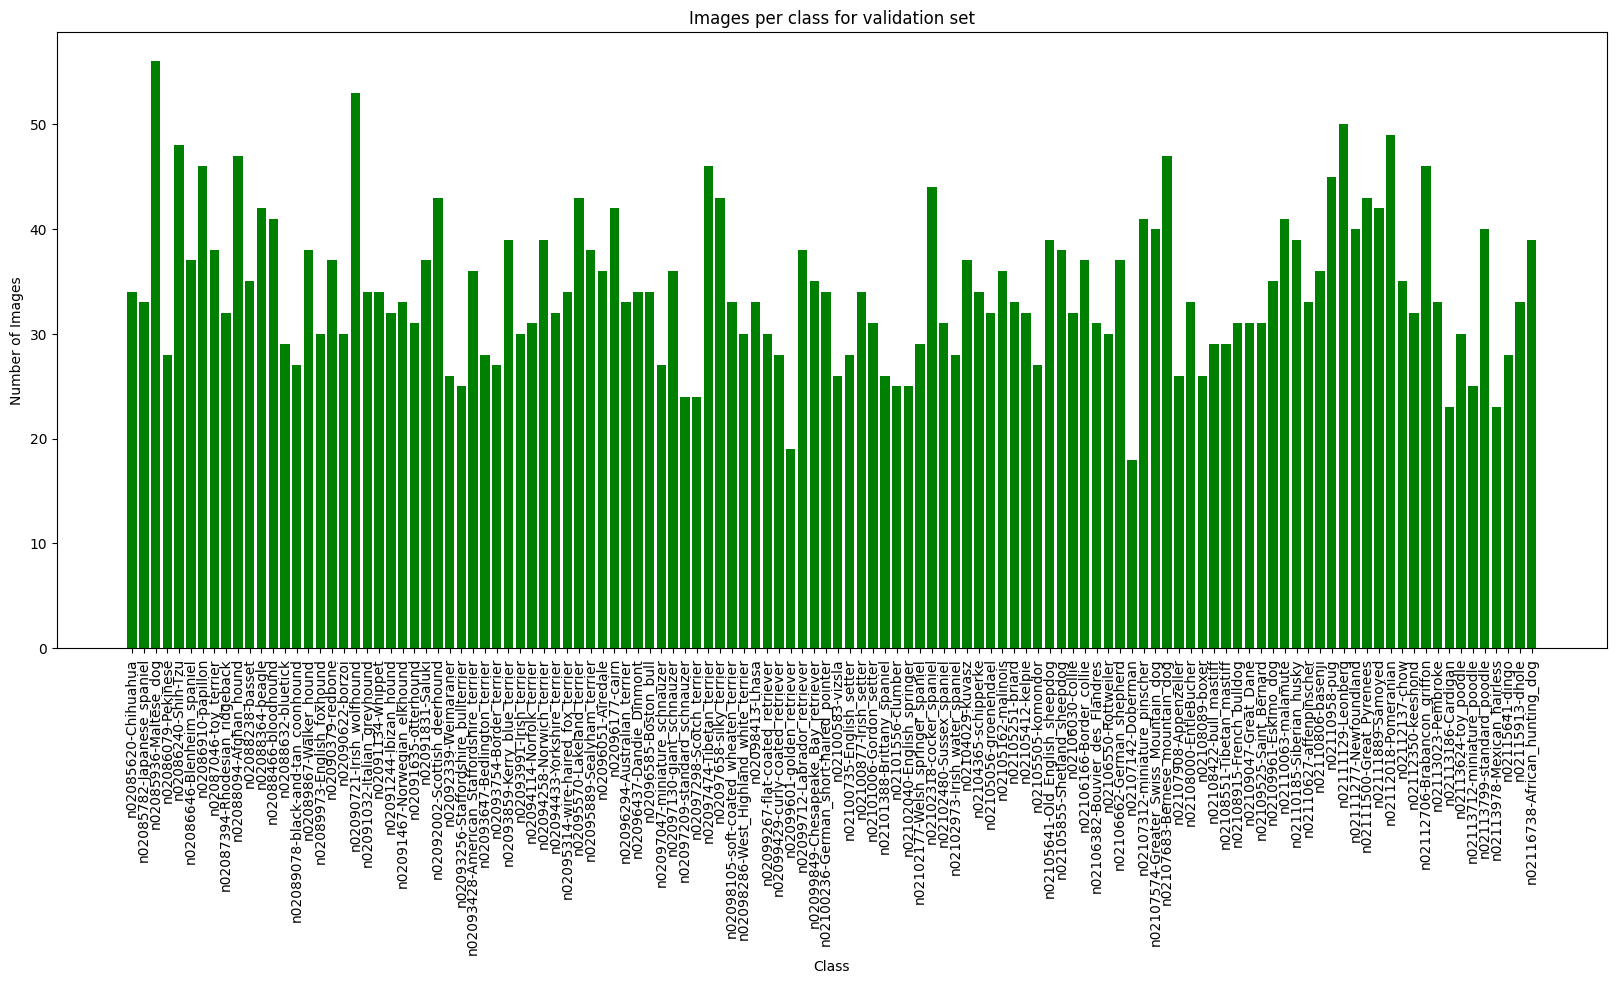

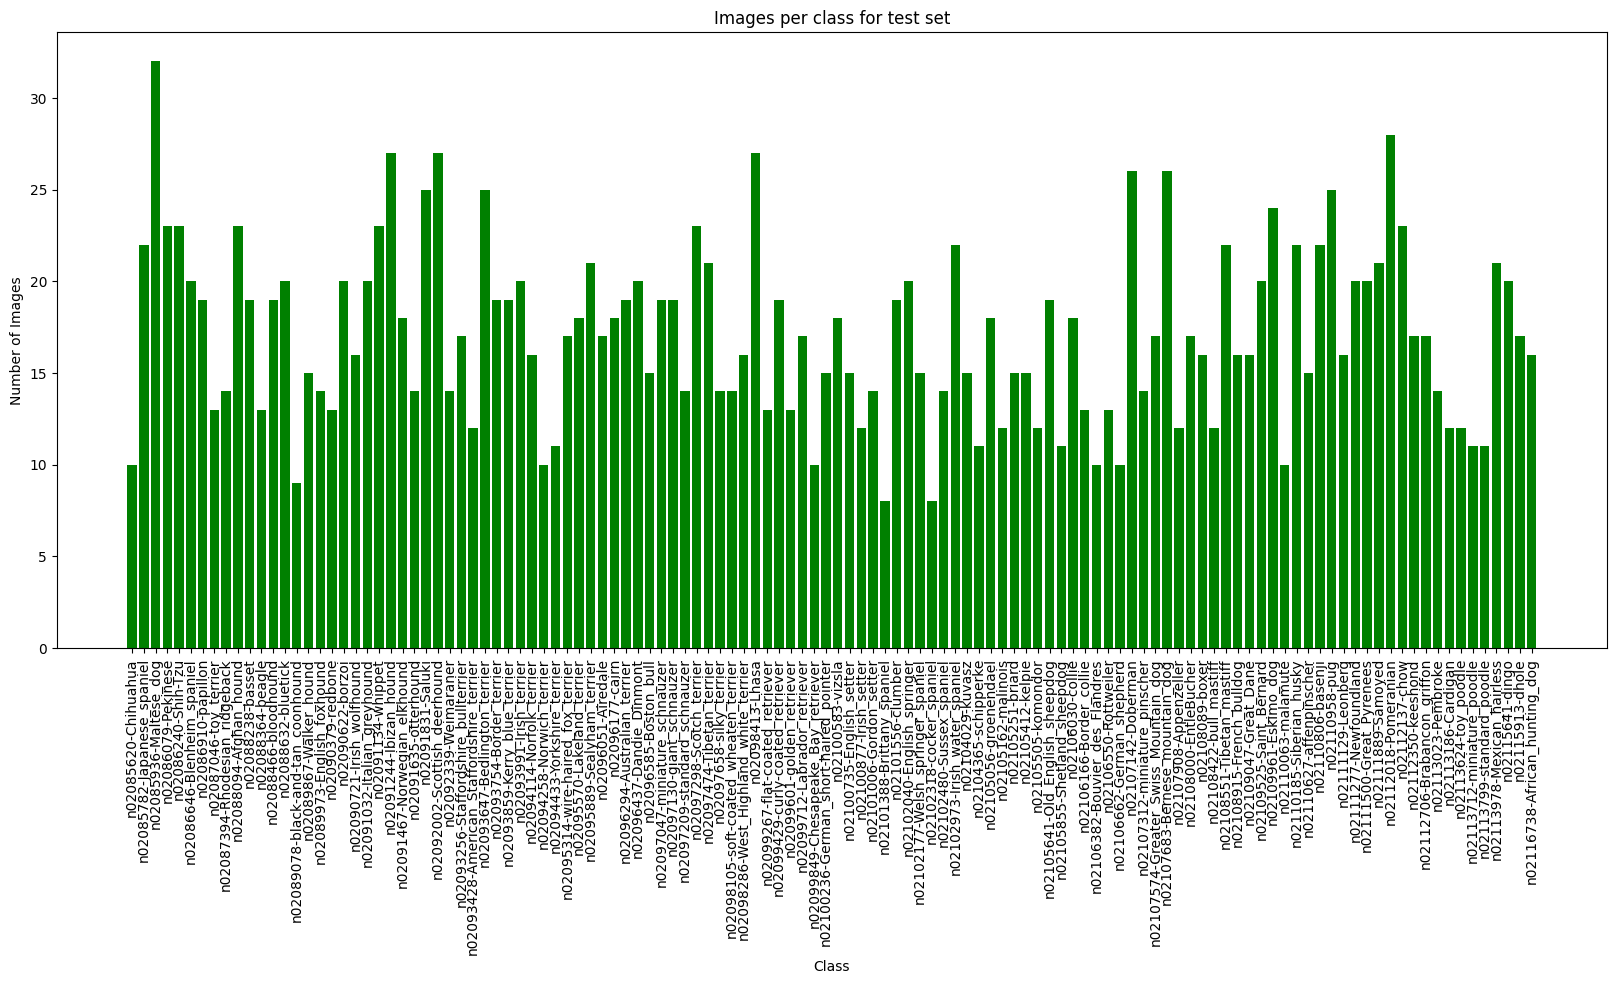

In [28]:
plot_classes(training_set, dataset.classes, set_name="training")
plot_classes(validation_set, dataset.classes, set_name="validation")
plot_classes(testing_set, dataset.classes, set_name="test")

## Image Vizualization

[  169  3350 15800  9810 15457 19503]


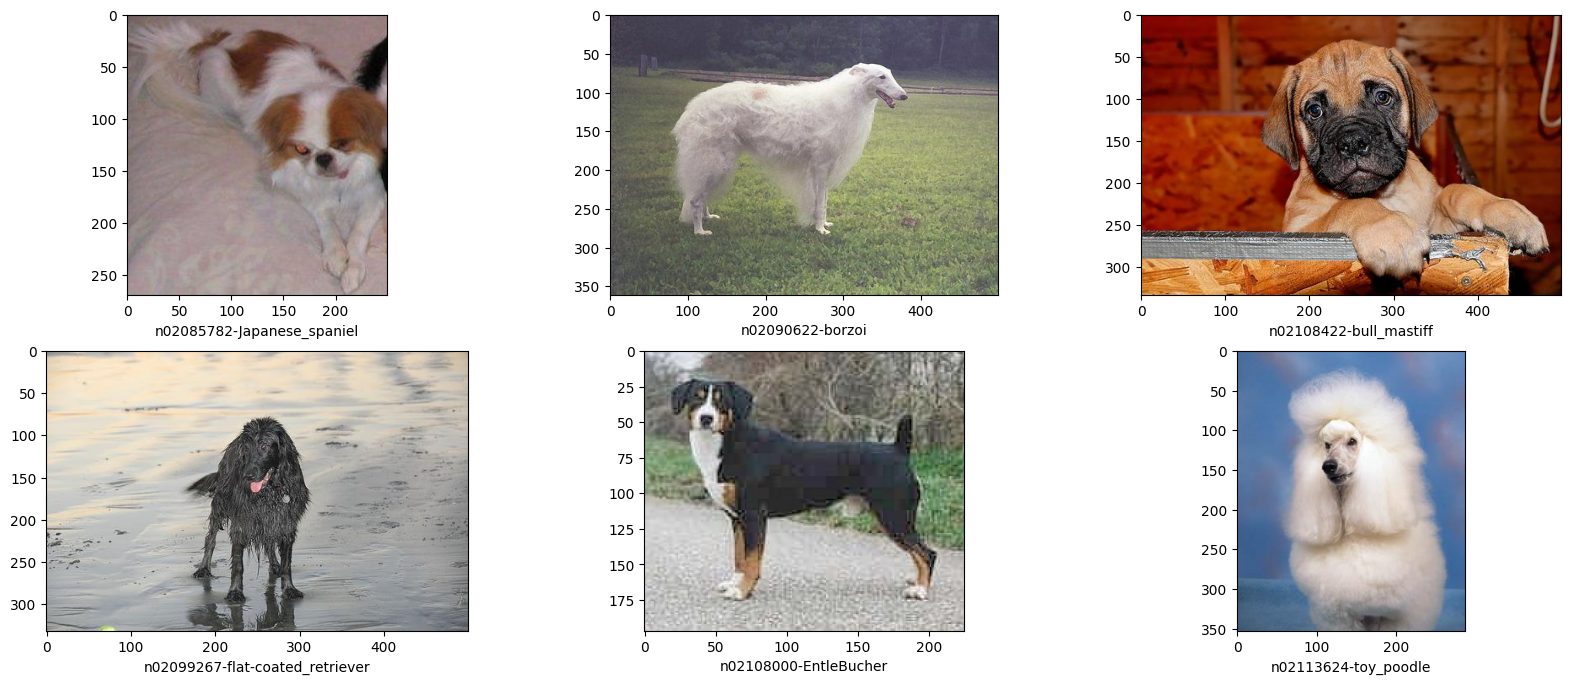

In [12]:
photos = datasets.ImageFolder(root=IMG_PATH)
plot_random_six_images(photos, photos.classes)

# DataLoaders

In [14]:
batch_size = 32


training_set_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_set_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
testing_set_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False)

# Loading ResNet Modela

In [21]:
net_model = resnet.resnet18(pretrained=True)
net_name = 'resnet18'

net_model

/home/franio/Desktop/Explainable_AI/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franio/Desktop/Explainable_AI/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Vizualizationb

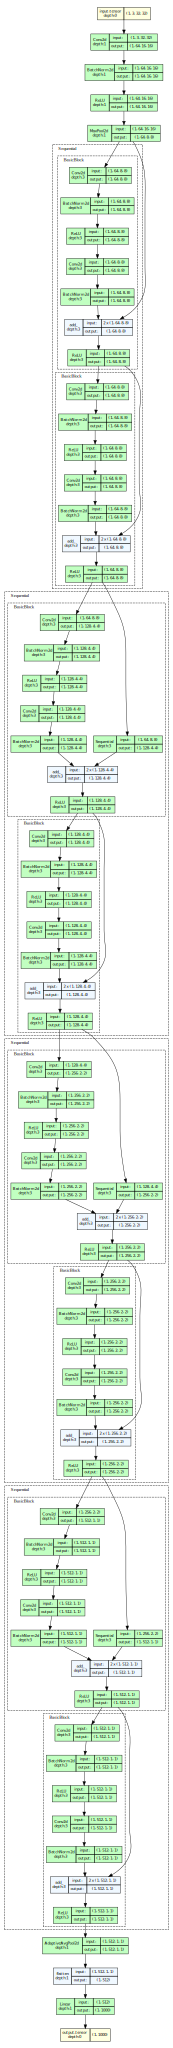

In [25]:
from torchview import draw_graph

model_graph = draw_graph(resnet.resnet18(), input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

### Unfreezing Layers

In [27]:
dropout_ratio = 0.9
unfrozen_layers = ['layer4', 'fc']

for name, child in net_model.named_children():
    if name in unfrozen_layers:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

total_params = sum(param.numel() for param in net_model.parameters())
print(f'{total_params:,} total parameters')

total_trainable_params = sum(param.numel() for param in net_model.parameters() if param.requires_grad)
print(f'{total_trainable_params:,} training parameters')


conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen
11,689,512 total parameters
8,906,728 training parameters


# Model Training

## Training

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1650 Ti
